*Created by Petteri Nevavuori (<petteri.nevavuori@gmail.com>)*

---
# Appendix A. Assessing the Models

In this notebook we will ~~train our model once more with the hyperparamers~~ generate outputs for our best performing models found during the optimization process. We will also visualize how our trained model's output matches to the real target values.

In [14]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from field_analysis.model.nets.cnn import DroneYieldMeanCNN
import field_analysis.model.dataset.dataperiod as dp

db_128 = 'field_analysis_40m_128px.db'
ds_earlier = dp.DroneRGBEarlier(db_128)
ds_later = dp.DroneRGBLater(db_128)

models_dir = os.path.join(os.getcwd(),'models')

print('Loading DroneYieldMeanCNN for Earlier RGB')

earlier_model_name = '20181121_201256583_Adadelta_3x128x128_10cnn_2fc.pkl'
earlier_model_path = os.path.join(models_dir,earlier_model_name)
cnn_earlier = DroneYieldMeanCNN(source_bands=3,source_dim=128,cnn_layers=10)
cnn_earlier.model_filename = earlier_model_name
cnn_earlier.model_path = earlier_model_path
cnn_earlier.load_model()

print('Loading DroneYieldMeanCNN for Later RGB')

later_model_name = '20181121_221638527_Adadelta_3x128x128_10cnn_2fc.pkl'
later_model_path = os.path.join(models_dir,later_model_name)
cnn_later = DroneYieldMeanCNN(source_bands=3,source_dim=128,cnn_layers=10)
cnn_later.model_filename = later_model_name
cnn_later.model_path = later_model_path
cnn_later.load_model()

Loading DroneYieldMeanCNN for Earlier RGB
Reading the model from C:\Users\karmus\Documents\Projektit\crop-yield-cnn\models\20181121_201256583_Adadelta_3x128x128_10cnn_2fc.pkl
Loading DroneYieldMeanCNN for Later RGB
Reading the model from C:\Users\karmus\Documents\Projektit\crop-yield-cnn\models\20181121_221638527_Adadelta_3x128x128_10cnn_2fc.pkl


In [2]:
def produce_output(cnn, dataset):
    y_trues, y_preds = [],[]
    with torch.set_grad_enabled(False):
        for item in dataset:
            y_trues.append(item['y'].item())
            y_preds.append(cnn(item['x'].unsqueeze(0).float().cuda()).item())

    df = pd.DataFrame(columns=['y_true','y_pred'])
    df.loc[:,'y_true'] = y_trues
    df.loc[:,'y_pred'] = y_preds
    df.to_csv(os.path.join(os.getcwd(),'results',f'targets_predictions_{dataset.__class__.__name__[8:].lower()}.csv'))
    return df

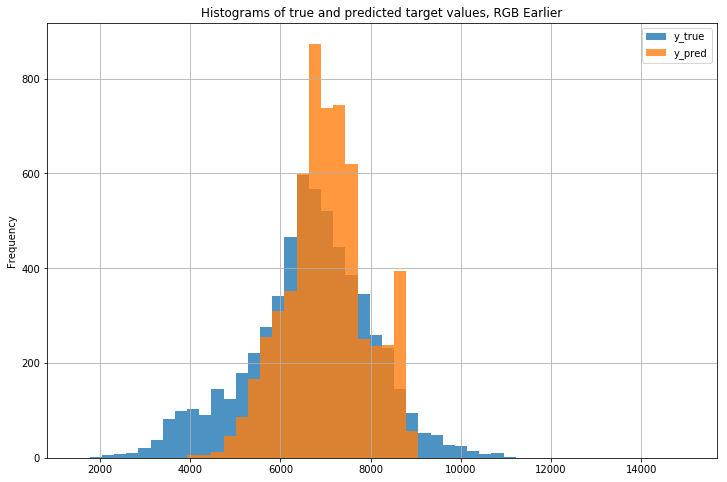

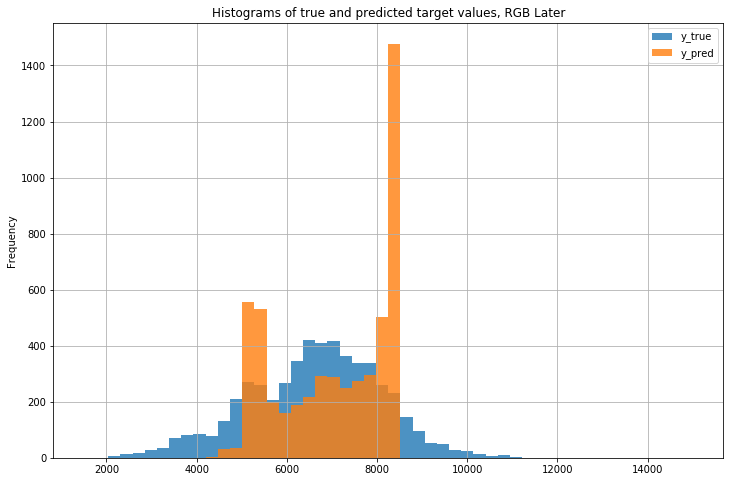

In [12]:
out_earlier = produce_output(cnn_earlier, ds_earlier)
out_later = produce_output(cnn_later, ds_later)

out_earlier.plot(kind='hist',figsize=(12,8),grid=True,bins=50,alpha=0.8,range=(1500,15000),
                 title='Histograms of true and predicted target values, RGB Earlier')
out_later.plot(kind='hist',figsize=(12,8),grid=True,bins=50,alpha=0.8,range=(1500,15000),
                 title='Histograms of true and predicted target values, RGB Later')

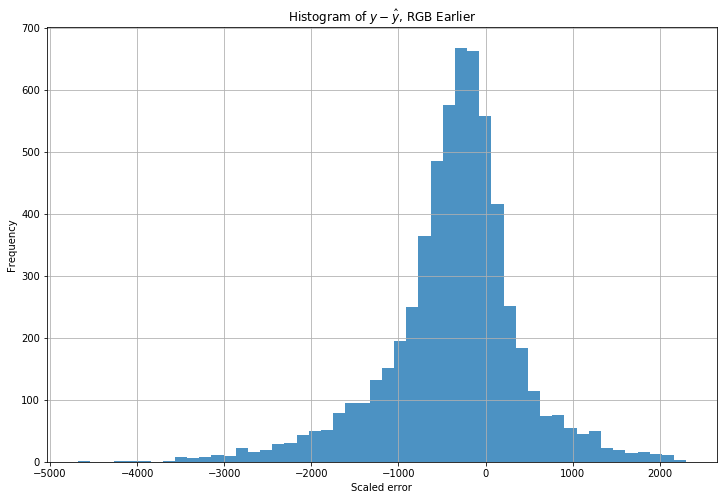

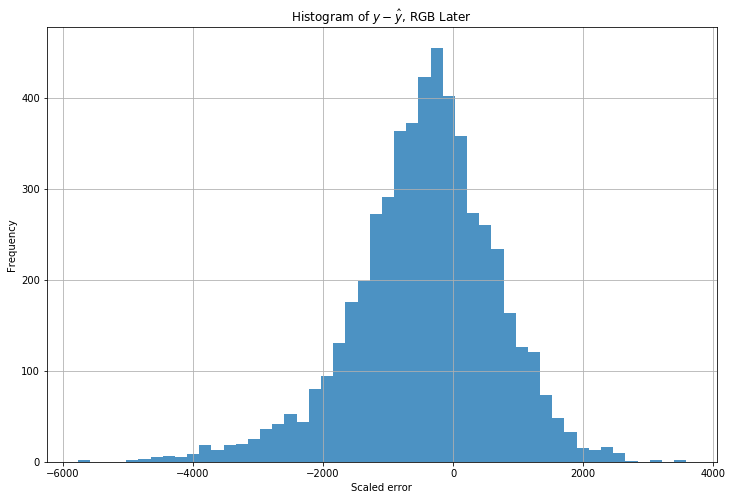

In [24]:
(out_earlier.y_true-out_earlier.y_pred).plot(
    kind='hist',figsize=(12,8),grid=True,bins=50,alpha=0.8,
    title='Histogram of $y-\hat{y}$, RGB Earlier')
plt.xlabel('Scaled error')
plt.show()

(out_later.y_true-out_later.y_pred).plot(
    kind='hist',figsize=(12,8),grid=True,bins=50,alpha=0.8,
    title='Histogram of $y-\hat{y}$, RGB Later')
plt.xlabel('Scaled error')
plt.show()

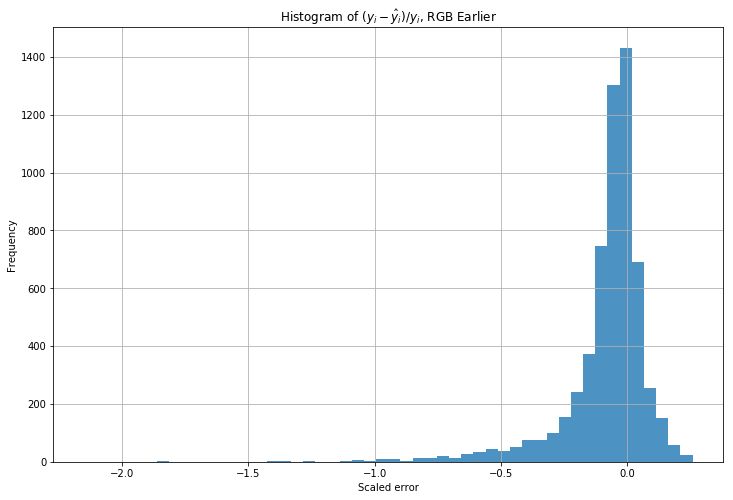

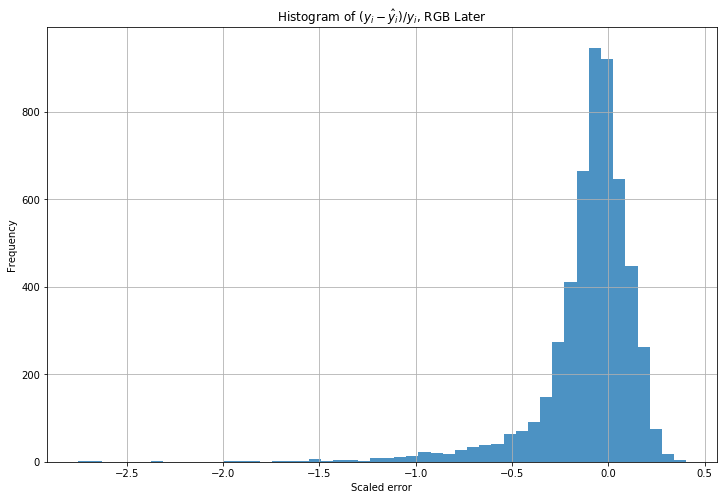

In [25]:
((out_earlier.y_true-out_earlier.y_pred)/out_earlier.y_true).plot(
    kind='hist',figsize=(12,8),grid=True,bins=50,alpha=0.8,
    title='Histogram of $(y_i-\hat{y}_i)/y_i$, RGB Earlier')
plt.xlabel('Scaled error')
plt.show()

((out_later.y_true-out_later.y_pred)/out_later.y_true).plot(
    kind='hist',figsize=(12,8),grid=True,bins=50,alpha=0.8,
    title='Histogram of $(y_i-\hat{y}_i)/y_i$, RGB Later')
plt.xlabel('Scaled error')
plt.show()